# Predicting Tempo from Lyrics

#### Add in a short summary


-------------

In [1]:
# Classic Packages
import pandas as pd

# Modeling 
from xgboost import plot_importance

#Plotting
import matplotlib.pyplot as plt

# Model Modules
from modules.feature_engineering import *
from modules.feature_reduction import *
from modules.model_build import *
from modules.clean_data import *
from modules.hyperopt_xgboost import *
from modules.hyperopt_hyperparameter import *

## Load Data

In [2]:
data_link = '../build_training/spotify_artist_info_nlp.csv'

In [3]:
song_df, song_features = generate_model_dataframe(pd.read_csv(data_link))

In [4]:
y_var = ['tempo']

## Preprocessing

### Feature Engineering

# fix genres
song_df, song_features = clean_genres(song_df, song_features)

# release date -> release year
song_df, song_features = release_year(song_df, song_features)

In [5]:
song_features = set_dependent_variable(song_df, song_features, y_var)

In [6]:
# drop records where lyrics are not scored through NLP model
song_df = song_df[(~song_df.POSITIVE.isna()) & 
                    (~song_df.acousticness.isna())].reset_index(drop=True)

### Data Cleaning

song_df, song_features = remove_columns_from_feature_set(song_df, song_features, ['artist_name','genres','album_type'])

In [7]:
song_features = remove_id_columns_from_feature_set(song_features)

The features removed from feature set:

lyric_location




In [8]:
song_df = clean_continuous_numeric_columns(song_df, song_features)

The features converted to float64:

NEGATIVE
POSITIVE
acousticness
anger
danceability
disgust
duration_ms_x
energy
fear
instrumentalness
joy
liveness
loudness
neutral
sadness
speechiness
surprise
tempo
valence




In [9]:
song_df = clean_ordinal_categorical_columns(song_df, song_features)

The features converted to category:






In [10]:
song_df.isna().sum()

NEGATIVE            0
POSITIVE            0
acousticness        0
anger               2
danceability        0
disgust             2
duration_ms_x       0
energy              0
fear                2
instrumentalness    0
joy                 2
key                 0
liveness            0
loudness            0
lyric_location      0
mode                0
neutral             2
popularity          0
sadness             2
speechiness         0
surprise            2
tempo               0
time_signature      0
valence             0
dtype: int64

In [11]:
song_df = clean_binary_categorical_columns(song_df, song_features)

The features converted to 0/1 integer:

mode




In [12]:
# check max number of missing values per column
song_df.isna().sum().max()

2

In [13]:
## feature correlation
song_features = highly_correlated_features(song_df, song_features, corr_threshold = 0.95)

The featurees dropped for correlation >= 0.95:

POSITIVE




## Model Building

In [14]:
## split data into train/test
training, _, _, _, X_test, y_test, _, _ = create_testing_dataframes(song_df, 
                                                              ids = ['lyric_location'],
                                                              stratify_by=['key'],
                                                              dv=y_var,
                                                              nfolds=5)

# split training into train & validation
_, _, X_train, y_train, X_val, y_val, _, _ = create_testing_dataframes(song_df, 
                                                          ids = ['lyric_location'],
                                                          stratify_by=['key'],
                                                          dv=y_var,
                                                          nfolds=5)

In [15]:
feature_space = create_hyperopt_feature_space(song_features[song_features['in_model'] == 1]['feature'].tolist())
hyperparameter_space = create_hyperopt_hyperparameters_space('xgb_regressor')

In [16]:
## train model

hyperopt_regression_model = Hyperopt_XGB('xgb_regressor',
                                         X_train,
                                         y_train,
                                         X_val,
                                         y_val,
                                         feature_space,
                                         hyperparameter_space)

feature_list, regression_model = hyperopt_regression_model.optimize(max_evals = 1500)

100%|██████████| 1500/1500 [06:39<00:00,  3.76trial/s, best loss: 22.642661046545378]


## Model Evaluation

In [17]:
model_columns = [feature for feature in feature_list.keys() if feature_list[feature] == 1 and feature not in hyperparameter_space.keys()]

In [18]:
model_columns

['acousticness',
 'anger',
 'disgust',
 'energy',
 'mode',
 'neutral',
 'time_signature']

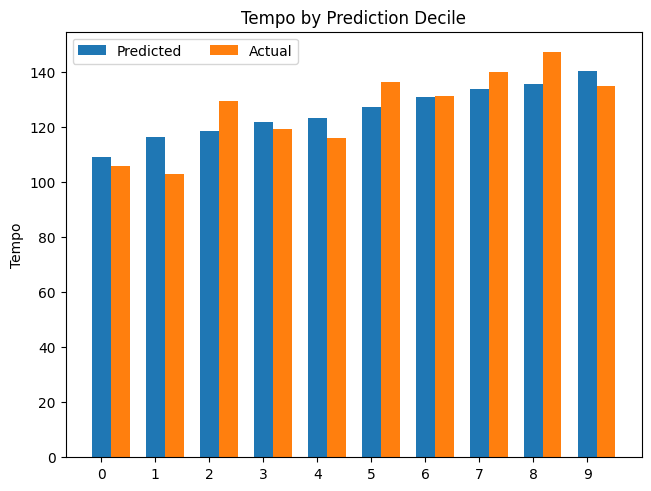

2

In [19]:
lift_chart(regression_model.predict(X_test[model_columns]), list(y_test.iloc[:,0])).shape[1]

In [20]:
## residual plot??

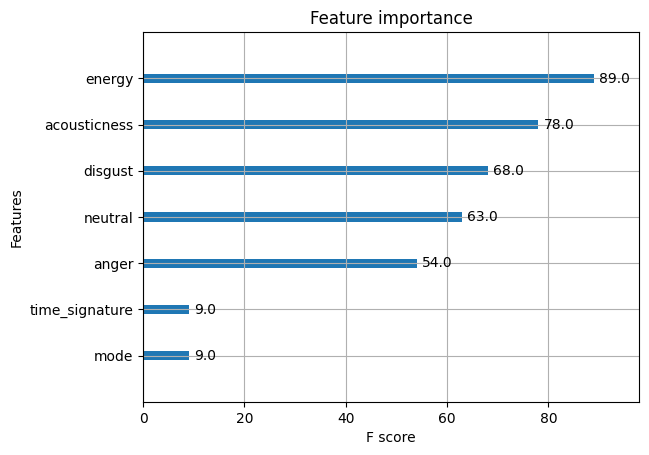

In [21]:
## Feature importance
plot_importance(regression_model);

## SHAP Plots